## Simple example using pykegg

### Convert to `igraph`, overlay on the raw KEGG image

IGRAPH DN-T 58 22 --
+ attr: bgcolor (v), coords (v), fgcolor (v), graphics_name (v), group (v),
  height (v), id (v), name (v), orig_id (v), original_type (v), pathway_name
  (v), type (v), width (v), x (v), xmax (v), xmin (v), y (v), ymax (v), ymin
  (v), entry1_orig_id (e), entry2_orig_id (e), reaction (e), subtypes (e),
  type (e)
+ edges (vertex names):
hsa:22909->undefined, undefined->hsa:57697, hsa:83990->undefined,
hsa:83990->undefined, hsa:91442->hsa:9894, undefined->hsa:2175,
undefined->hsa:2189, undefined->hsa:55215, undefined->hsa:57697,
hsa:9894->hsa:545, hsa:57697->hsa:91442, hsa:57697->hsa:100526739 hsa:201254
hsa:378708, undefined->hsa:55215, undefined->hsa:2177, hsa:2177->hsa:675,
undefined->hsa:5889, hsa:675->hsa:5888, hsa:2177->hsa:22909, hsa:545->hsa:672,
undefined->hsa:55120, undefined->hsa:57697, undefined->hsa:29935 hsa:6117
hsa:6118 hsa:6119


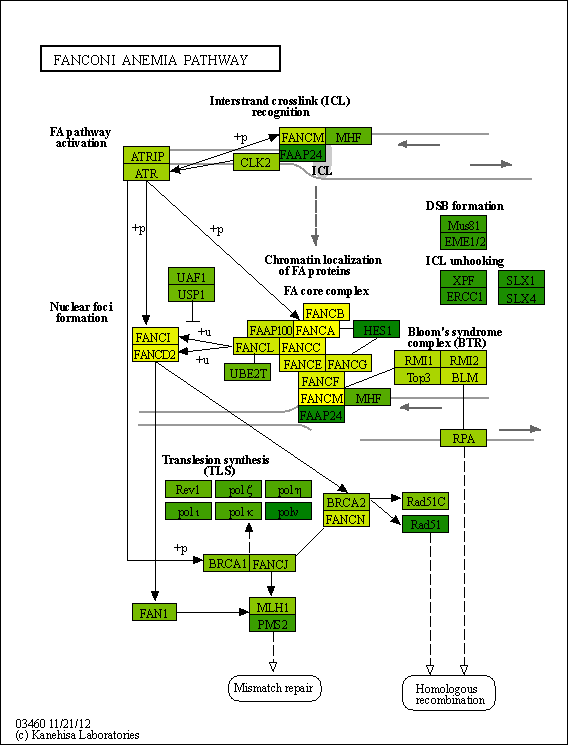

In [1]:
import requests_cache
import numpy as np
from PIL import Image
import pykegg
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

## Make sure to cache all the downloaded files to avoid recursive connection
requests_cache.install_cache('pykegg_cache')
graph = pykegg.KGML_graph(pid="hsa03460")

## Export as igraph
igra = graph.get_graph()
print(igra)

## Overlay to raw image
nds = graph.get_nodes()

## Assign random color
nds = nds[nds.original_type=="gene"]
nds["lfc"] = np.arange(-2,2,0.01)[0:nds.shape[0]]
cmap_grad = mpl.colors.LinearSegmentedColormap.from_list("cmap_grad", ["yellow","green"])
norm = mpl.colors.Normalize(vmin=min(nds.lfc), vmax=max(nds.lfc))
nds["color"] = [
        mpl.colors.to_hex(cmap_grad(norm(x))) if x is not None else None
        for x in nds.lfc
    ]
Image.fromarray(pykegg.overlay_opencv_image(nds, pid="hsa03460"))

### Plot using plotnine

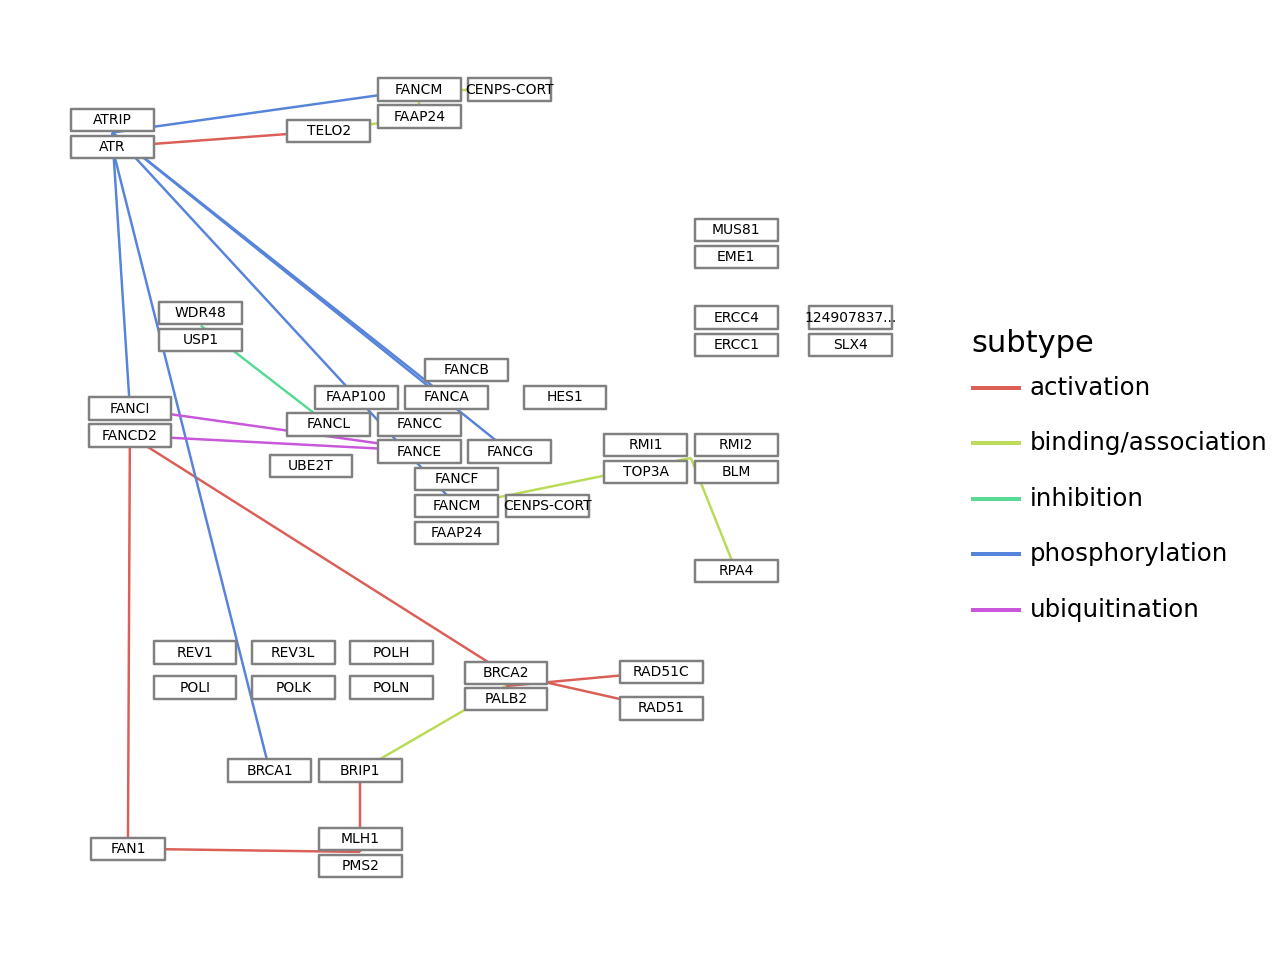

<Figure Size: (640 x 480)>

In [2]:

# options.figure_size = (7,5)
pykegg.plot_kegg_pathway_plotnine(graph, node_x_nudge=25, label_size=5, show_label="gene")

### Customization of nodes and edges
In `plot_kegg_pathway_plotnine`, various geoms are used to plot KEGG PATHWAY information.
Users would like to customize the visualization such as using arrows for directed relationships.
Some functions are prepared for this purpose, outlined below.

In [3]:
from plotnine import (
    ggplot,
    options,
    geom_point,
    geoms,
    aes,
    geom_segment,
    theme_void,
    geom_rect,
    geom_text,
)
graph = pykegg.KGML_graph(pid="hsa04110") ## Cell cycle
options.figure_size = (12, 9) ## Change plotnine plot size
node_df = graph.get_nodes(node_x_nudge=20, node_y_nudge=10) ## Change the node size
seg_df = pykegg.return_segments(graph) ## return edge data frame for the use in `geom_segment`
seg_df2 = seg_df.apply(lambda x: pykegg.shorten_end(x, 0.8), axis=1) ## shorten end of edges for visualization of arrow
hsa = pykegg.id_to_name_dict("hsa") ## Obtain dict for converting hsa* IDs
node_df["converted"] = node_df["name"].apply(lambda x: pykegg.convert_id(x, hsa)) ## Convert ID

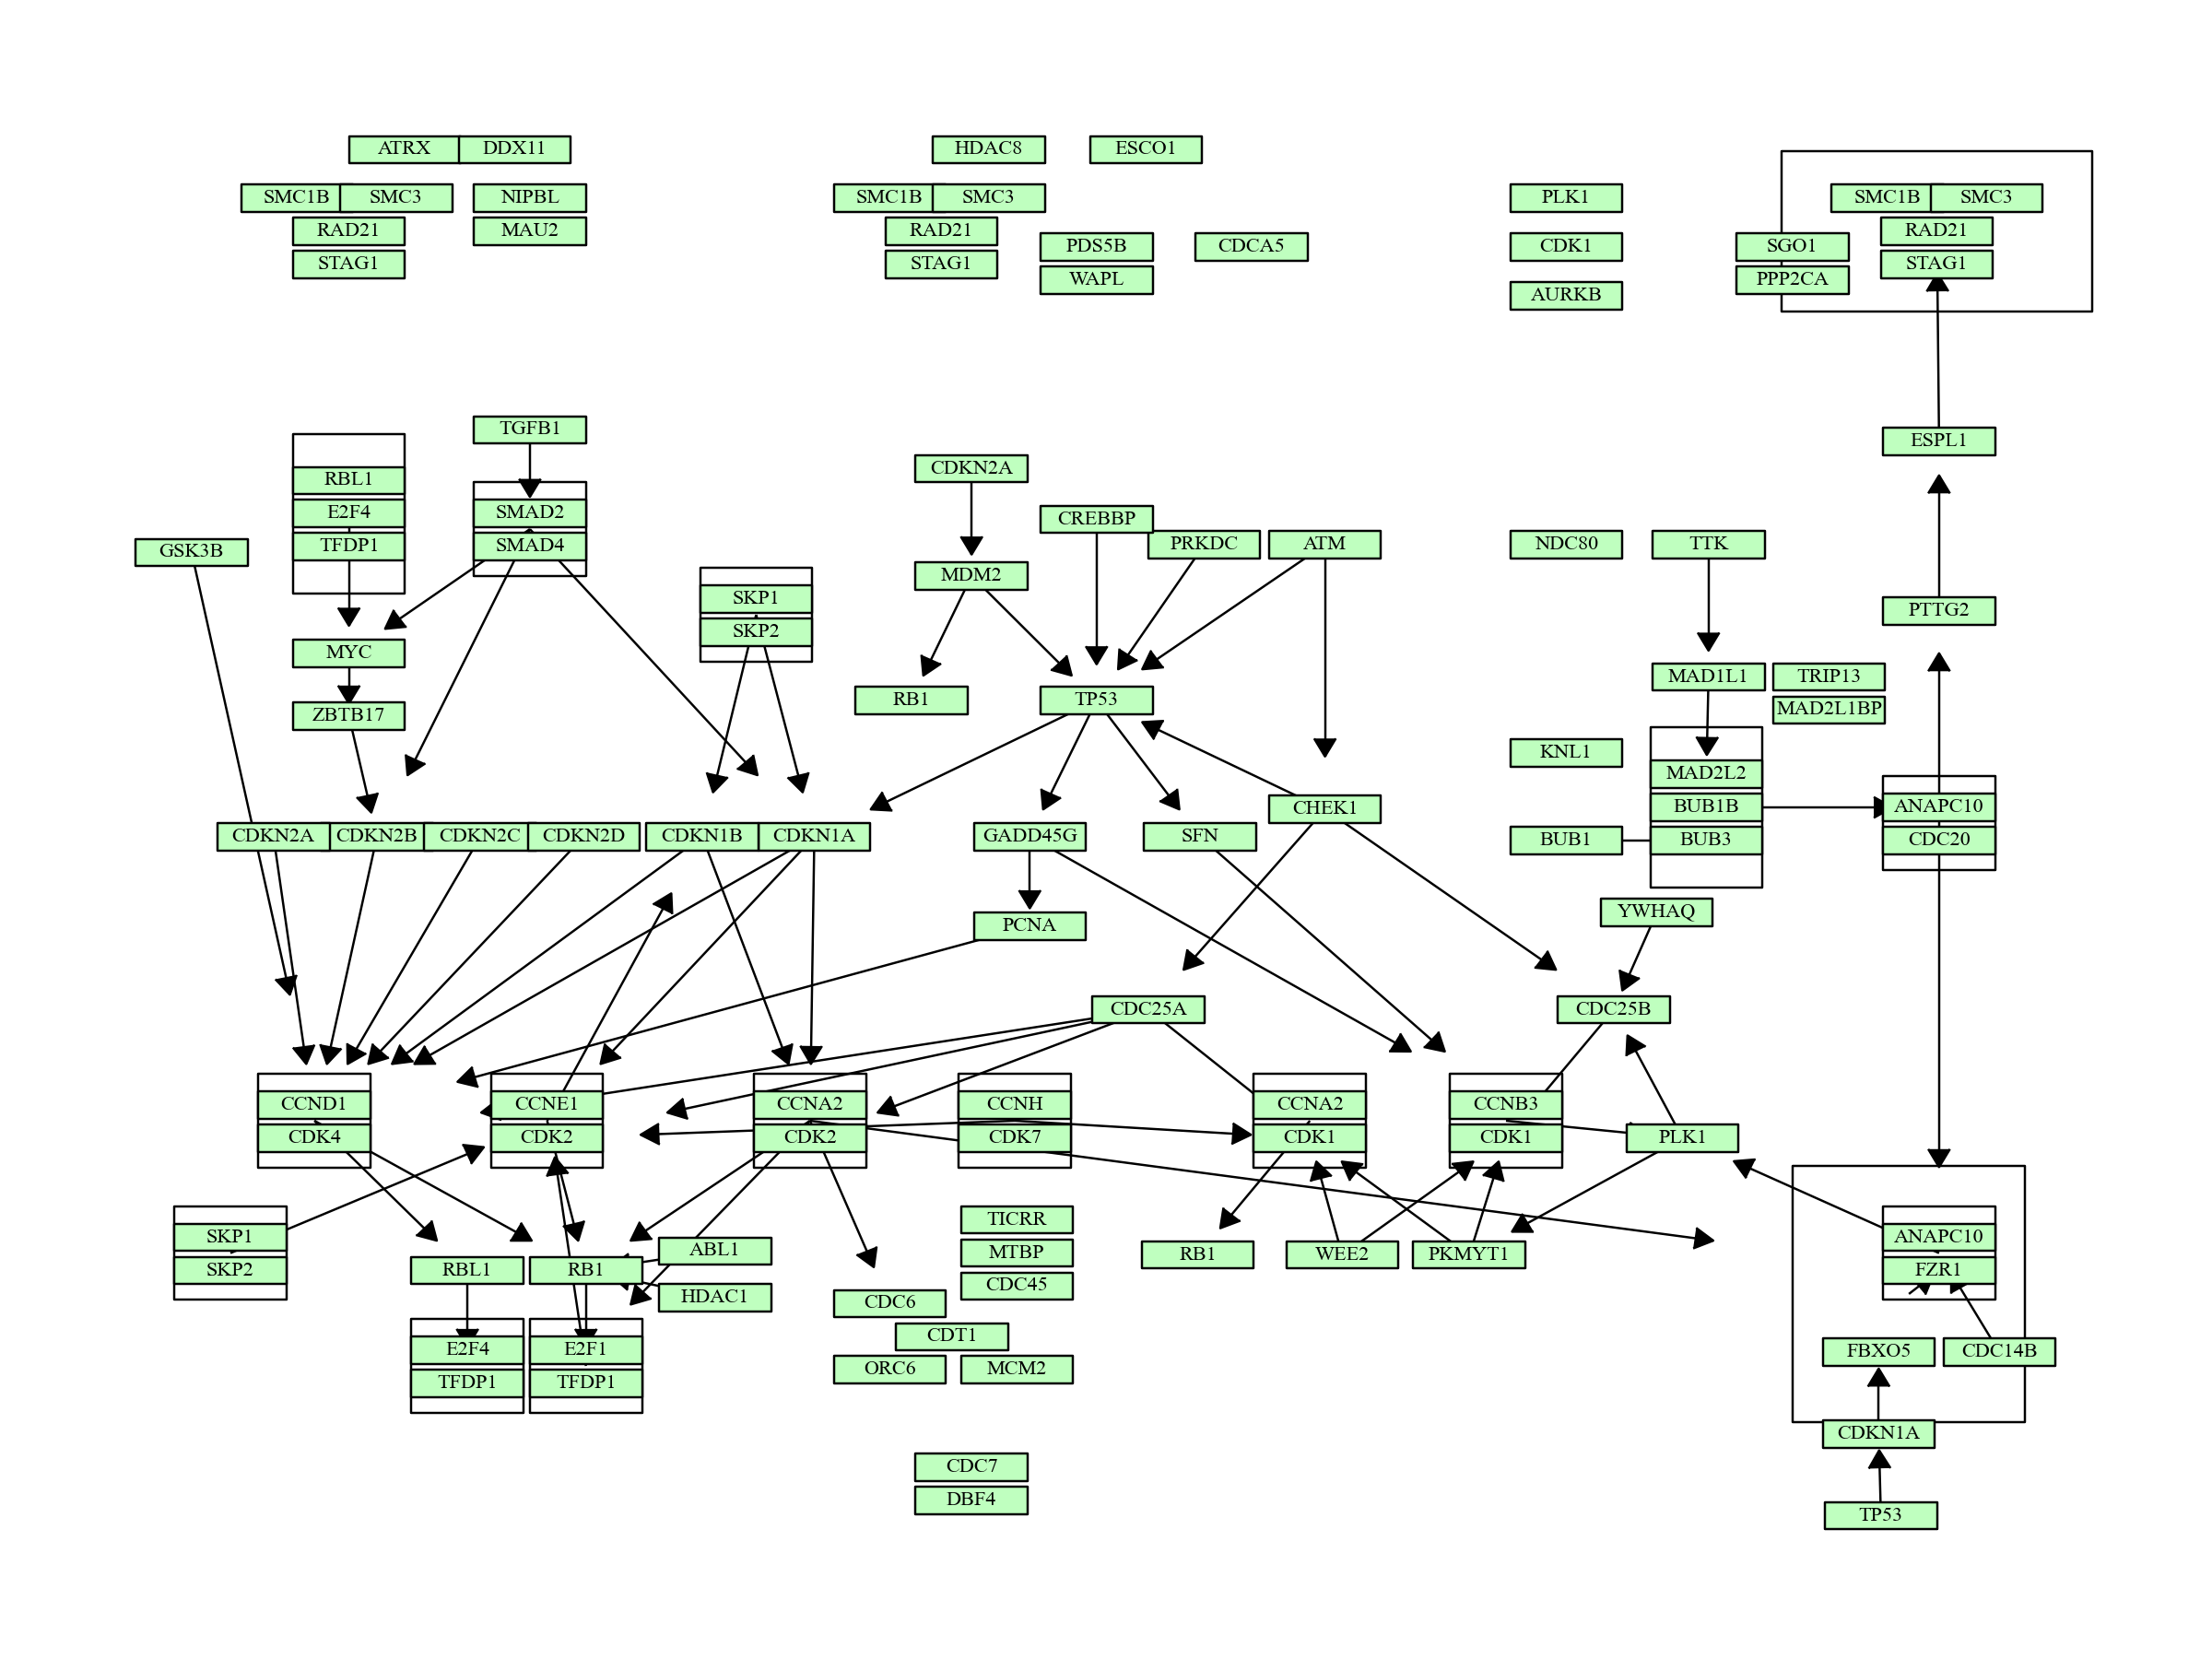

<Figure Size: (1200 x 900)>

In [4]:
(
        ggplot()
         + geom_segment(
            aes(x="x", y="y", xend="xend", yend="yend"), data=seg_df2,
            arrow=geoms.arrow(type="closed", length=0.05)
         )
        + geom_rect(
            aes(xmin="xmin", ymin="ymin", xmax="xmax", ymax="ymax"),
            data=node_df[node_df.original_type == "group"],
            color="black", alpha=0, fill="#ffffff"
            )
        + geom_rect(
            aes(xmin="xmin", ymin="ymin", xmax="xmax", ymax="ymax"),
            data=node_df[node_df.original_type == "gene"],
            color="black",
            fill=node_df[node_df.original_type == "gene"].bgcolor)
           +geom_text(
             aes(x="x",y="y", label="converted"),
               family="serif", size=8,
            data=node_df[node_df.original_type == "gene"],
            color="black"       
           )+
    theme_void()
 
    
)